In [54]:
#lettura dati

def leggi_dati(file_path):
    # Inizializza liste per ogni colonna
    angle, rate, err_rate = [], [], []
    count, err_count = [], []
    channel, err_channel = [], []
    sigma, err_sigma = [], []

    with open(file_path, 'r') as file:
        lines = file.readlines()

        # Salta l'intestazione
        for line in lines[1:]:
            valori = line.strip().split()
            if len(valori) != 9:
                continue  # Salta righe non valide

            angle.append(float(valori[0]))
            rate.append(float(valori[1]))
            err_rate.append(float(valori[2]))
            count.append(float(valori[3]))
            err_count.append(float(valori[4]))
            channel.append(float(valori[5]))
            err_channel.append(float(valori[6]))
            sigma.append(float(valori[7]))
            err_sigma.append(float(valori[8]))

    return angle, rate, err_rate, count, err_count, channel, err_channel, sigma, err_sigma

file_path = "../../Codes/data_analysis/parameters_pol4_riflection.txt"

angle, rate, err_rate, count, err_count, channel, err_channel, sigma, err_sigma = leggi_dati(file_path)

file_path = "../../Codes/data_analysis/parameters_pol4_trasmission.txt"

angle_trasm, rate_trasm, err_rate_trasm, count_trasm, err_count_trasm, channel_trasm, err_channel_trasm, sigma_trasm, err_sigma_trasm = leggi_dati(file_path)

In [55]:
import numpy as np

data = np.load('../../Measurments/errori_arrays_energies_riflex.npz')
y_err = data['y_err']
x_err = data['x_err']

print(y_err, x_err)

data = np.load('../../Measurments/errori_arrays_energies_trasm.npz')
y_err_trasm = data['y_err']
x_err_trasm = data['x_err']

print(y_err_trasm, x_err_trasm)

[22.84938822 24.73515897 25.06882476 24.16920639 23.90927847 23.60367868
 23.7813561  21.84229732] 0.026549250386340584
[21.86974645 22.60325593 23.58308884 24.5744343 ] 0.026549250386340584


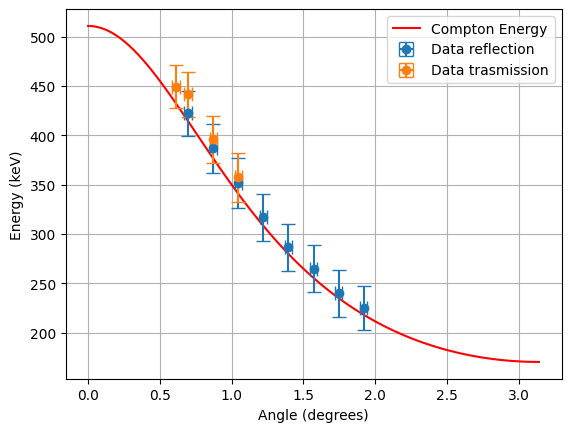

In [56]:
import matplotlib.pyplot as plt

def compton_energy(theta): 
    return 511 / (2 - np.cos(theta))

def calibration(x, a = 0.36, b = -11.5):
    """
    Calibration function for converting ADC channels to energy in keV.
    
    :param x: ADC channel value.
    :param a: Calibration coefficient (default: 0.36).
    :param b: Calibration offset (default: -11.5).
    :return: Energy in keV.
    """
    return a * x + b

thetas = np.linspace(0, np.pi, 100)
angle = np.radians(angle)
angle_trasm = np.radians(angle_trasm)
energies = calibration(np.array(channel))
energies_trasm = calibration(np.array(channel_trasm))

plt.plot(thetas, compton_energy(thetas), label='Compton Energy', color='red')
plt.errorbar(angle, energies, xerr=x_err, yerr=y_err, fmt='o', capsize=5, label='Data reflection')
plt.errorbar(angle_trasm, energies_trasm, xerr=x_err_trasm, yerr=y_err_trasm, fmt='o', capsize=5, label='Data trasmission')
plt.xlabel('Angle (degrees)')
plt.ylabel('Energy (keV)')
plt.legend()
plt.grid()
plt.show()

TRASMISSIONE
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │    640    │    90     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
Chi2: 0.36, NDF: 3.0


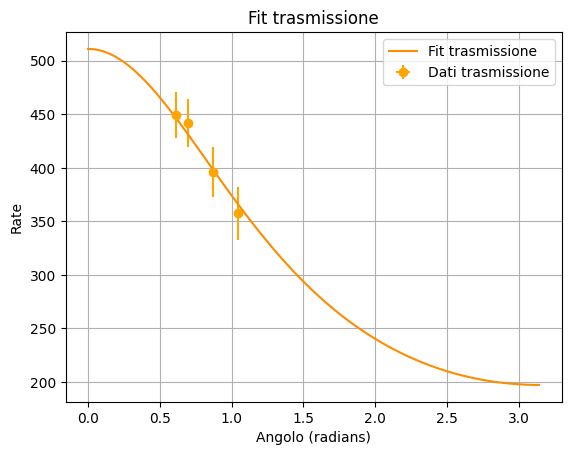


--- RISULTATI TRASMISSIONE ---
Fitted value of a: 642.4938618781031
Error on a: 92.91261551301
Compatibilità:  -1.4152422806318565


In [57]:
from iminuit import Minuit
from iminuit.cost import LeastSquares

# === Funzione da fittare ===
def fit_function(theta, a):
    return 511 / (1 + (511/a) * (1 - np.cos(theta)))

# === Fit ===
least_squares = LeastSquares(angle_trasm, energies_trasm, y_err_trasm, fit_function)
m = Minuit(least_squares, a=511)
m.migrad()

# === Risultati ===
print("TRASMISSIONE")
print(m.params)
print(f"Chi2: {m.fval:.2f}, NDF: {m.ndof}")

# === Plot ===
plt.errorbar(angle_trasm, energies_trasm, yerr=y_err_trasm, xerr=x_err_trasm, fmt='o', color='orange', label='Dati trasmissione')
a_fit_reflection = m.values["a"]
a_err_reflection = m.errors["a"]
plt.plot(thetas, fit_function(thetas, a_fit_reflection), label="Fit trasmissione", color='darkorange')

plt.xlabel("Angolo (radians)")
plt.ylabel("Rate")
plt.legend()
plt.grid()
plt.title("Fit trasmissione")
plt.show()

# === Calcolo m_e ===
print("\n--- RISULTATI TRASMISSIONE ---")
print(f"Fitted value of a: {a_fit_reflection}")
print(f"Error on a: {a_err_reflection}")


# === Confronto tra r_e ottenuti da riflessione e trasmissione ===
R = (511 - a_fit_reflection) / a_err_reflection
print ("Compatibilità: ", R)


TRASMISSIONE
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │    550    │    40     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
Chi2: 0.10, NDF: 7.0


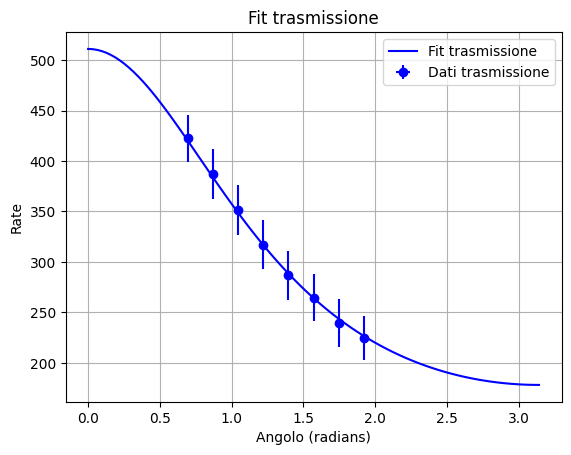


--- RISULTATI TRASMISSIONE ---
Fitted value of a: 547.4315352606038
Error on a: 39.71687192696382
Compatibilità:  -0.9172810821456063


In [58]:
# === Fit ===
least_squares = LeastSquares(angle, energies, y_err, fit_function)
m = Minuit(least_squares, a=511)
m.migrad()

# === Risultati ===
print("TRASMISSIONE")
print(m.params)
print(f"Chi2: {m.fval:.2f}, NDF: {m.ndof}")

# === Plot ===
plt.errorbar(angle, energies, yerr=y_err, xerr=x_err, fmt='o', color='blue', label='Dati trasmissione')
a_fit_trasmission = m.values["a"]
a_err_trasmission = m.errors["a"]
plt.plot(thetas, fit_function(thetas, a_fit_trasmission), label="Fit trasmissione", color='blue')

plt.xlabel("Angolo (radians)")
plt.ylabel("Rate")
plt.legend()
plt.grid()
plt.title("Fit trasmissione")
plt.show()

# === Calcolo m_e ===
print("\n--- RISULTATI TRASMISSIONE ---")
print(f"Fitted value of a: {a_fit_trasmission}")
print(f"Error on a: {a_err_trasmission}")


# === Confronto tra r_e ottenuti da riflessione e trasmissione ===
R = (511 - a_fit_trasmission) / a_err_trasmission
print ("Compatibilità: ", R)


(12,) (12,) (12,)
TOTALE
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │    570    │    40     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
Chi2: 1.49, NDF: 11.0


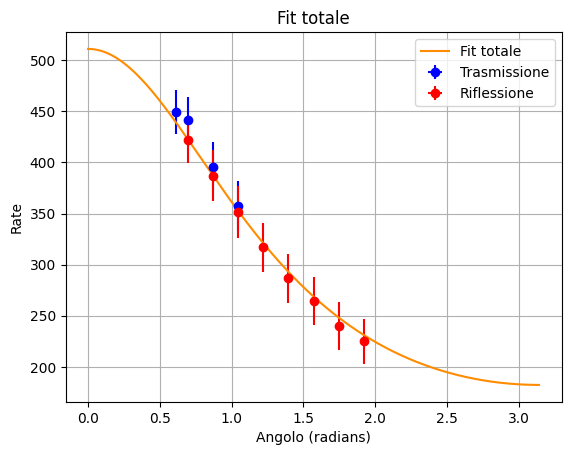


--- RISULTATI TRASMISSIONE ---
Fitted value of a: 567.0011908593509
Error on a: 36.21402202985177
Compatibilità:  -1.5463952281574325


In [62]:
# === Dataset totale per il fit ===
data_tot = np.concatenate((energies_trasm, energies))
angle_tot = np.radians(np.array([35, 40, 50, 60, 40, 50, 60, 70, 80, 90, 100, 110]))
data_err = np.concatenate((y_err_trasm, y_err))
print(data_tot.shape, angle_tot.shape, data_err.shape)

# === Fit ===
least_squares_trasm = LeastSquares(angle_tot, data_tot, data_err, fit_function)
m = Minuit(least_squares_trasm, a=511.0)
m.migrad()

# === Risultati ===
print("TOTALE")
print(m.params)
print(f"Chi2: {m.fval:.2f}, NDF: {m.ndof}")

# === Plot ===
thetas = np.linspace(0, np.pi, 2000)
a_fit_tot = m.values["a"]
a_err_tot = m.errors["a"]

plt.errorbar(angle_trasm, energies_trasm, yerr=y_err_trasm, xerr=x_err_trasm, fmt='o', label="Trasmissione", color='blue')
plt.errorbar(angle, energies, yerr=y_err, xerr=x_err, fmt='o', label="Riflessione", color='red')
plt.plot(thetas, fit_function(thetas, a_fit_tot), label="Fit totale", color='darkorange')

plt.xlabel("Angolo (radians)")
plt.ylabel("Rate")
plt.legend()
plt.grid()
plt.title("Fit totale")
plt.show()

# === Calcolo m_e ===
print("\n--- RISULTATI TRASMISSIONE ---")
print(f"Fitted value of a: {a_fit_tot}")
print(f"Error on a: {a_err_tot}")


# === Confronto tra r_e ottenuti da riflessione e trasmissione ===
R = (511 - a_fit_tot) / a_err_tot
print ("Compatibilità: ", R)